According to the [proof](https://github.com/chengsoonong/eheye/tree/master/writing/QuantUCB_orderstat), the proposed policy for exponential distribution is:
In the t + 1 round, pick the arm with index,

$$argmax_{i \in \mathcal{K}} \hat{m}_{i, T_i(t)} + \sqrt{2v_t \varepsilon} + 2 \varepsilon \sqrt{v_t/T_i(t)}$$

where $\hat{m}_{i, T_i(t)}$ is the empirical median for arm i at the round t, $\varepsilon = 4 \log t$, $v_t = \frac{8 \sigma^2}{T_i(t) log2}$. $T_i(t)$ is the number of times arm i has been played until round t.  

However, the performance of this policy is much worse than the UCB1. There are two possible ideas to show the proposed policy can have a better performance than UCB1:

1. With the inspiration from the [UCB-V paper](http://certis.enpc.fr/~audibert/Mes%20articles/TCS08.pdf), a possible way is to tune hyperparamters $\alpha, \beta$:

$$argmax_{i \in \mathcal{K}} \hat{m}_{i, T_i(t)} + \beta(\sqrt{2v_t \varepsilon} + 2 \varepsilon \sqrt{v_t/T_i(t)})$$

where $\hat{m}_{i, T_i(t)}$ is the empirical median for arm i at the round t, $\varepsilon = \alpha \log t$, $v_t = \frac{8 \sigma^2}{T_i(t) log2}$. $T_i(t)$ is the number of times arm i has been played until round t. 

For the experiment, we first try $\alpha = [0.5, 1, 2, 3, 4]$, $\beta = [0.5, 1, 1.5, 2]$. Subsequence experiment can be designed based on the result. 

2. With the inspiration from the [robust statistics](https://psycnet.apa.org/record/1994-08189-001), adding outliers may make UCB1 out of control. So we design the experiment as: 
with probability p (p <= 0.2), the arms can return a high reward (i.e. outliers) , with probability (1-p), the rewards is sampled from exponential distributions with parameter $\theta_i$.

we first try p = [0.01, 0.05, 0.1, 0.2], outliers uniformly sampled from [50,60].

For both experiments, we set 1,000 rounds and 50 experiments, 3 arms with $\theta = [1, 0.5, 1.5]$

In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
#import statsmodels.api as sm
import pylab 
import itertools
from UCB_discrete import Environment
from UCB_discrete import UCB_os_gau, UCB_os_exp
from collections import defaultdict

%matplotlib inline

### Hyperparamter tuning

In [3]:
# setting

num_rounds = 5000
num_exper = 20
num_arms = 3
scales = [1, 2, 2.0/3] # lambda = 1, 0.5, 1.5

In [4]:
class Exp_Environment():
    """Environment for distribution reward of arms.
    """
    def __init__(self, scale=1.0, size = None):  
        self.scale = scale
        self.size = size
        
    def sample(self):
        # f = 1/scale exp(-x/scale)
        return np.random.exponential(self.scale, self.size)

In [5]:
rewards_env = []
medians = []
means = []

num_samples = 10000

for i in range(num_arms):
    rewards_env.append(Exp_Environment(scale = scales[i]))
    medians.append(np.median(np.random.exponential(scale = scales[i], size = num_samples)))
    means.append(np.mean(np.random.exponential(scale = scales[i], size = num_samples)))
    
print('medians are: ', medians)
print('means are: ', means)

best_arm = np.argmax(medians)

medians are:  [0.6849522858330583, 1.381944334333288, 0.461623701701804]
means are:  [0.9911725423449455, 2.007084722979309, 0.6609898456913603]


In [6]:
# use estimate variance

expected_regrets_true_var_exp_list = {}
alpha_list = [0.5, 1, 2, 4]
beta_list = [0.5, 1, 1.5] 

for beta in beta_list:
    for alpha in alpha_list:
        regrets = []
        for i in range(num_exper):
            agent = UCB_os_exp(rewards_env, num_rounds, medians, est_var = False, alpha = alpha, beta = beta)
            regrets.append(agent.play())
    
        np.asarray(regrets).reshape((num_exper, num_rounds-3))
        expected_regrets_true_var_exp_list[alpha, beta] = np.mean(regrets, axis = 0)

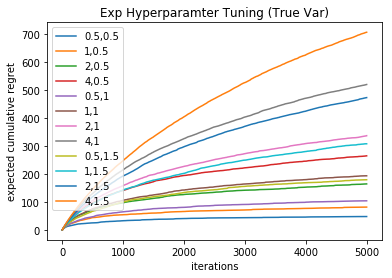

In [7]:
for beta in beta_list:
    for alpha in alpha_list:
        label = str(alpha) + ',' + str(beta) 
        plt.plot(expected_regrets_true_var_exp_list[alpha, beta], label = label)
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Exp Hyperparamter Tuning (True Var)')
plt.legend()

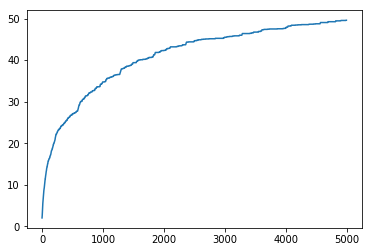

In [8]:
plt.plot(expected_regrets_true_var_exp_list[2, 1.5])

From the above experiments, we can see hyperparameters do influence the performance greatly. We set alpha = 4, beta = 1, the cumulative regret can reach 160 at the 1000th iteration. While setting alpha = 0.2, beta = 0.5, the cumulative regret is only around 10 at 1000th iteration. But when alpha, beta is too small, the selection is mainly based on the medians, the confidence bound part can barely influence the selection, so we should avoid that. 

In [12]:
%%capture

# use estimated variance

num_rounds = 5000

expected_regrets_est_var_exp_list = {}
alpha_list = [0.5, 1, 2, 4]
beta_list = [0.5, 1, 1.5] 

for beta in beta_list:
    for alpha in alpha_list:
        regrets = []
        for i in range(num_exper):
            agent = UCB_os_exp(rewards_env, num_rounds, medians, est_var = True, alpha = alpha, beta = beta)
            regrets.append(agent.play())
    
        np.asarray(regrets).reshape((num_exper, num_rounds-3))
        expected_regrets_est_var_exp_list[alpha, beta] = np.mean(regrets, axis = 0)

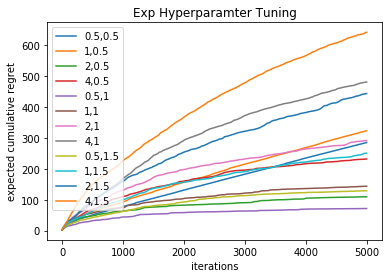

In [13]:
for beta in beta_list:
    for alpha in alpha_list:
        label = str(alpha) + ',' + str(beta) 
        plt.plot(expected_regrets_est_var_exp_list[alpha, beta], label = label)
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Exp Hyperparamter Tuning')
plt.legend()

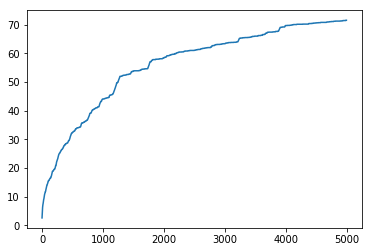

In [15]:
plt.plot(expected_regrets_est_var_exp_list[0.5,1], label = label)

however, the esitmated variance influences the performance a lot. We choose a set of hyperparameter having a good performance for both estimated and true variance. 

In [22]:
%%capture

num_rounds = 1000
num_exper = 50

regrets = []

for i in range(num_exper):
    agent = UCB_os_exp(rewards_env, num_rounds, medians, est_var = True, alpha = 0.5, beta = 0.5)
    regrets.append(agent.play())
    
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets_true_var_exp = np.mean(regrets, axis = 0)

The policy for UCB1 is:

$$\hat{\mu}_t + \sqrt{\frac{2 \alpha^2 \log t}{T_i(t-1)}}$$

where $\hat{\mu}_t$ is the sample mean at round t, the rewards of arms are bounded $[0, \alpha]$, $T_i(t-1)$ is the number of time arm i has been played until the round t. In this case, the largest rewards of arms is around 1.5, so we set $\alpha = 1.5$. 

In [17]:
%%capture

from UCB_discrete import UCB1_os

alpha = 1.5

regrets = []

for i in range(num_exper):
    agent = UCB1_os(rewards_env, num_rounds, medians, alpha)
    regrets.append(agent.play())
    
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets_UCB1_os = np.mean(regrets, axis = 0)

NameError: name 'expected_regrets_true_var_exp' is not defined

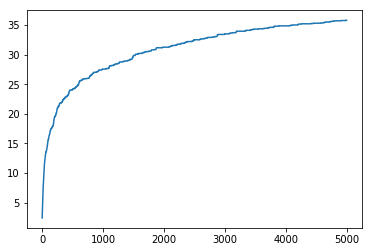

In [18]:
plt.plot(expected_regrets_UCB1_os, label = 'UCB1 os')
plt.plot(expected_regrets_true_var_exp, label = '0.2,0.5')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Exp')
plt.legend()

From the above results, we can see our policy can beat UCB1 with hyperparameters tuning properly. 

### Outliers

To show the influence of the outliers, we choose alpha = 1, beta = 1 for our policy, where without outliers, the performance of both policy is:

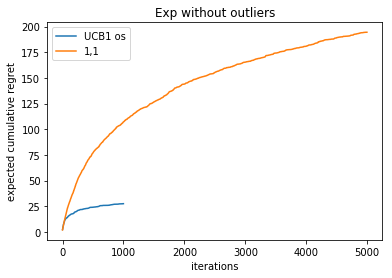

In [19]:
plt.plot(expected_regrets_UCB1_os[: 1000], label = 'UCB1 os')
plt.plot(expected_regrets_true_var_exp_list[1,1], label = '1,1')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Exp without outliers')
plt.legend()

In [20]:
class Exp_Environment_with_outliers():
    """Environment for distribution reward of arms.
    """
    def __init__(self, scale=1.0, size = None, p = 0.1, a = 50, b = 60):  
        self.scale = scale
        self.size = size
        self.p = p
        self.a = a
        self.b = b
        
    def sample(self):
        # f = 1/scale exp(-x/scale)
        if np.random.uniform() <= self.p:
            return np.random.uniform(self.a, self.b)
        else:
            return np.random.exponential(self.scale, self.size)

(array([8933.,   15.,    0.,    0.,    0.,    0.,    0.,    0.,  399.,
         653.]),
 array([2.84609801e-04, 6.00005741e+00, 1.19998302e+01, 1.79996030e+01,
        2.39993758e+01, 2.99991486e+01, 3.59989214e+01, 4.19986942e+01,
        4.79984670e+01, 5.39982398e+01, 5.99980126e+01]),
 <a list of 10 Patch objects>)

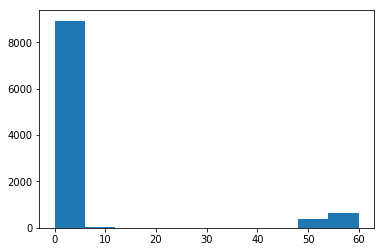

In [21]:
# plot samples

num_samples = 10000
samples = []
sampler = Exp_Environment_with_outliers()

for i in range(num_samples):
    samples.append(sampler.sample())
    
plt.hist(samples)

In [22]:
rewards_env_with_outliers = []
medians = []
means = []
num_samples = 10000
samples = []

for i in range(num_arms):
    sampler = Exp_Environment_with_outliers(scale = scales[i])
    rewards_env_with_outliers.append(sampler)
    for j in range(num_samples):
        samples.append(sampler.sample())
    medians.append(np.median(samples))
    means.append(np.mean(samples))
    
print('medians are: ', medians)
print('means are: ', means)

best_arm = np.argmax(medians)

medians are:  [0.8381508200911285, 1.1488125452872158, 0.8862920071119591]
means are:  [6.54823729296849, 6.8689101199218054, 6.644346768215647]


In [33]:
%%capture

# p = [0.01, 0.05, 0.1, 0.2]
num_rounds = 1000

regrets = []

for i in range(num_exper):
    agent = UCB_os_exp(rewards_env_with_outliers, num_rounds, medians, est_var = False, alpha = 1, beta = 1)
    regrets.append(agent.play())
    
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets_true_var_exp_withoutliers = np.mean(regrets, axis = 0)

In [34]:
%%capture

from UCB_discrete import UCB1_os

regrets = []

for i in range(num_exper):
    agent = UCB1_os(rewards_env_with_outliers, num_rounds, medians, alpha = 1)
    regrets.append(agent.play())
    
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets_UCB1_os_withoutliers = np.mean(regrets, axis = 0)

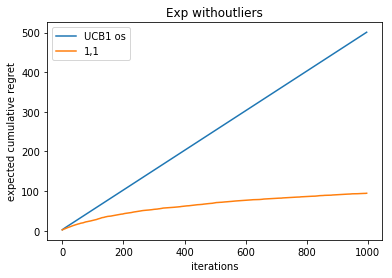

In [35]:
plt.plot(expected_regrets_UCB1_os_withoutliers, label = 'UCB1 os')
plt.plot(expected_regrets_true_var_exp_withoutliers, label = '1,1')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Exp withoutliers')
plt.legend()

From the above experiment, we can see when adding outliers, UCB1 performs much worse than our policy. UCB1 has a linear regret, reaching 350 regret at 1000th iterations. Then we show the performance for our policy with the hyperparameters we selected above (alpha = 0.2, beta = 0.5), for 10,000 iterations.

In [47]:
%%capture

# p = [0.01, 0.05, 0.1, 0.2]
num_rounds = 10000

regrets = []

for i in range(num_exper):
    agent = UCB_os_exp(rewards_env_with_outliers, num_rounds, medians, est_var = False, alpha = 0.2, beta = 0.5)
    regrets.append(agent.play())
    
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets_true_var_exp_withoutliers = np.mean(regrets, axis = 0)

In [49]:
%%capture

regrets = []

for i in range(num_exper):
    agent = UCB_os_exp(rewards_env, num_rounds, medians, est_var = False, alpha = 0.2, beta = 0.5)
    regrets.append(agent.play())
    
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets_true_var_exp = np.mean(regrets, axis = 0)

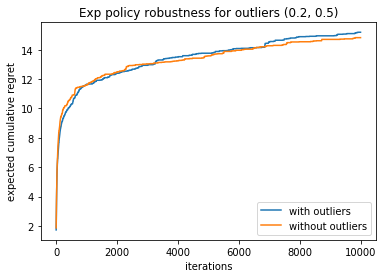

In [50]:
plt.plot(expected_regrets_true_var_exp_withoutliers, label = 'with outliers')
plt.plot(expected_regrets_true_var_exp, label = 'without outliers')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Exp policy robustness for outliers (0.2, 0.5)')
plt.legend()

From the above plot, we can see our policy is not influenced by the outliers. The performance of our policy is almost the same for the cases with and without outliers. 

### Evaluate UCB1 by mean

However, the above analysis is evaluated by regret in terms of medians, which is kind of unfair to UCB1, which is designed for mean. Then we run the experiment for UCB1 with outliers, and evaluated by regret in terms of means.

In [55]:
%%capture

# evaluate by regret defined in terms of mean

regrets = []

for i in range(num_exper):
    agent = UCB1_os(rewards_env_with_outliers, num_rounds, means)
    regrets.append(agent.play())
    
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets_UCB1_withoutliers = np.mean(regrets, axis = 0)

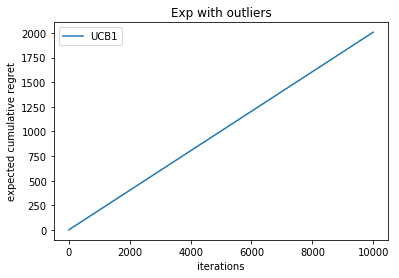

In [56]:
plt.plot(expected_regrets_UCB1_withoutliers, label = 'UCB1')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Exp with outliers')
plt.legend()

From the plot we can see UCB1 performs bad (linear regret) even it is evaluate by means when there are outliers.

### Future directions

There are a few UCB algorithms designed for skewed distribution, see [paper reading notes](https://github.com/chengsoonong/eheye/tree/master/writing/Paper_reading_notes). Think about what the adv and disadv for your policy compared with theirs. Design experiment to compare. 

## For normal distribution

Similar to the exponential distribution, we explore the performance of normal distribution case in terms of tuning hyperparameters and adding outliers. 

According to the [proof](https://github.com/chengsoonong/eheye/tree/master/writing/QuantUCB_orderstat), the proposed policy for abosulte value of centered normal distribution is:
In the t + 1 round, pick the arm with index,

$$argmax_{i \in \mathcal{K}} \hat{m}_{i, T_i(t)} + \sqrt{2v_t \varepsilon} + 2 \varepsilon \sqrt{v_t/T_i(t)}$$

where $\hat{m}_{i, T_i(t)}$ is the empirical median for arm i at the round t, $\varepsilon = 4 \log t$, $v_t = \frac{8 \sigma^2}{T_i(t) log2}$. $T_i(t)$ is the number of times arm i has been played until round t.  

There are two possible ideas:

1. With the inspiration from the [UCB-V paper](http://certis.enpc.fr/~audibert/Mes%20articles/TCS08.pdf), a possible way is to tune hyperparamters $\alpha, \beta$:

$$argmax_{i \in \mathcal{K}} \hat{m}_{i, T_i(t)} + \beta(\sqrt{2v_t \varepsilon} + 2 \varepsilon \sqrt{v_t/T_i(t)})$$

where $\hat{m}_{i, T_i(t)}$ is the empirical median for arm i at the round t, $\varepsilon = \alpha \log t$, $v_t = \frac{8 \sigma^2}{T_i(t) log2}$. $T_i(t)$ is the number of times arm i has been played until round t. 

For the experiment, we first try $\alpha = [0.5, 1, 2, 3, 4]$, $\beta = [0.5, 1, 1.5, 2]$. Subsequence experiment can be designed based on the result. 

2. With the inspiration from the [robust statistics](https://psycnet.apa.org/record/1994-08189-001), adding outliers may make UCB1 out of control. So we design the experiment as: 
with probability p (p <= 0.2), the arms can return a high reward (i.e. outliers) , with probability (1-p), the rewards is sampled from exponential distributions with parameter $\theta_i$.

we first try p = [0.01, 0.05, 0.1, 0.2], outliers uniformly sampled from [50,60].

For both experiments, we set 1,000 rounds and 50 experiments, 3 arms with $\theta = [1, 0.5, 1.5]$

In [2]:
num_rounds = 1000
num_exper = 10
num_arms = 3

In [3]:
rewards_env = []
medians = []
num_sample = 1000000

for i in range(num_arms):
    # rewards distribution of arms is gaussian distribution with 
    # mean as 0, variance as i.
    rewards_env.append(Environment(loc = 0, scale = (i + 1) * 0.1))
    medians.append(np.median(Environment(loc = 0, scale = (i + 1) * 0.1, size = num_sample).sample()))
    
best_arm = np.argmax(medians)
print('medians are: ', medians)
print('best arm is ', best_arm)

medians are:  [0.06749888910243698, 0.1347568294498926, 0.2021488621474608]
best arm is  2


In [15]:
# use true variance

expected_regrets_true_var_gau_list = {}
alpha_list = [0.2, 0.5, 1, 2]
beta_list = [0.2, 0.5, 1, 1.5] 

for beta in beta_list:
    for alpha in alpha_list:
        regrets = []
        for i in range(num_exper):
            agent = UCB_os_gau(rewards_env, num_rounds, medians, est_var = False, alpha = alpha, beta = beta)
            regrets.append(agent.play())
    
        np.asarray(regrets).reshape((num_exper, num_rounds-3))
        expected_regrets_true_var_gau_list[alpha, beta] = np.mean(regrets, axis = 0)

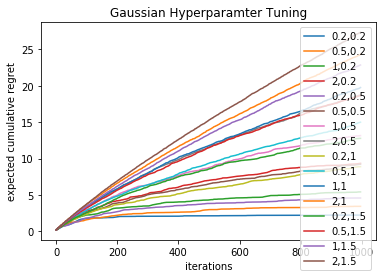

In [16]:
for beta in beta_list:
    for alpha in alpha_list:
        label = str(alpha) + ',' + str(beta) 
        plt.plot(expected_regrets_true_var_gau_list[alpha, beta], label = label)
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Gaussian Hyperparamter Tuning')
plt.legend()

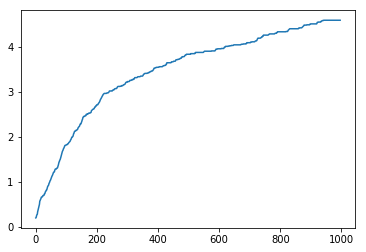

In [18]:
plt.plot(expected_regrets_true_var_gau_list[0.2,0.5])

From the above experiments, we can see hyperparameters do influence the performance greatly. We set alpha = 4, beta = 1, the cumulative regret can reach 30 at the 1000th iteration. While setting alpha = 0.2, beta = 0.5, the cumulative regret is only around 5 at 1000th iteration. But when alpha, beta is too small, the selection is mainly based on the medians, the confidence bound part can barely influence the selection, so we should avoid that. 

To show the choice of alpha and beta works for larger iterations, we choose alpha = 0.2, beta = 0.5, do experiment for num_rounds = 10,000. The results are shown below. 

In [19]:
%%capture

num_rounds = 10000

regrets = []

for i in range(num_exper):
    agent = UCB_os_gau(rewards_env, num_rounds, medians, est_var = False, alpha = 0.2, beta = 0.5)
    regrets.append(agent.play())
    
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets_true_var_gau = np.mean(regrets, axis = 0)

In [20]:
%%capture

from UCB_discrete import UCB1_os

regrets = []

for i in range(num_exper):
    agent = UCB1_os(rewards_env, num_rounds, medians)
    regrets.append(agent.play())
    
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets_UCB1_os = np.mean(regrets, axis = 0)

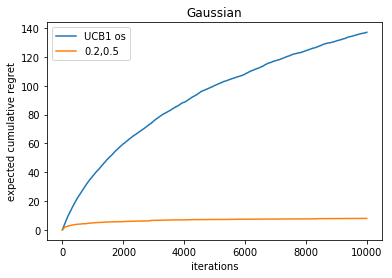

In [24]:
plt.plot(expected_regrets_UCB1_os, label = 'UCB1 os')
plt.plot(expected_regrets_true_var_gau, label = '0.2,0.5')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Gaussian')
plt.legend()

From the above results, we can see our policy can beat UCB1 with hyperparameters tuning properly. 

### Outliers

To show the influence of the outliers, we choose alpha = 1, beta = 0.5 for our policy, where without outliers, the performance of both policy is:

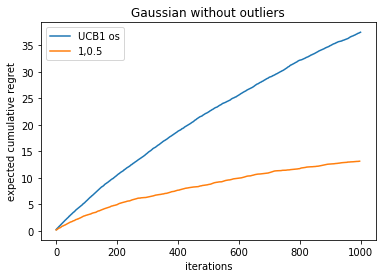

In [29]:
plt.plot(expected_regrets_UCB1_os[: 1000], label = 'UCB1 os')
plt.plot(expected_regrets_true_var_gau_list[1,0.5], label = '1,0.5')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Gaussian without outliers')
plt.legend()

In [32]:
class Gau_Environment_with_outliers():
    """Environment for distribution reward of arms.
    """
    def __init__(self, scale=1.0, size = None, p = 0.1, a = 50, b = 60):  
        self.scale = scale
        self.size = size
        self.p = p
        self.a = a
        self.b = b
        
    def sample(self):
        # f = 1/scale exp(-x/scale)
        if np.random.uniform() <= self.p:
            return np.random.uniform(self.a, self.b)
        else:
            return np.abs(np.random.normal(scale = self.scale, size = self.size))

(array([8938.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  452.,
         610.]),
 array([1.88817316e-04, 5.99978338e+00, 1.19993779e+01, 1.79989725e+01,
        2.39985671e+01, 2.99981616e+01, 3.59977562e+01, 4.19973508e+01,
        4.79969453e+01, 5.39965399e+01, 5.99961345e+01]),
 <a list of 10 Patch objects>)

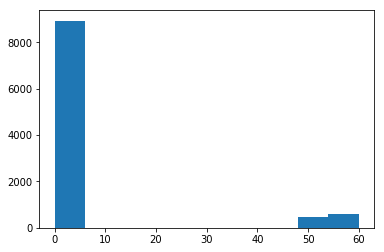

In [33]:
# plot samples

num_samples = 10000
samples = []
sampler = Gau_Environment_with_outliers()

for i in range(num_samples):
    samples.append(sampler.sample())
    
plt.hist(samples)

In [35]:
rewards_env_with_outliers = []
medians = []
means = []
num_samples = 10000
samples = []
scales = [0.1, 0.2, 0.3]

for i in range(num_arms):
    sampler = Gau_Environment_with_outliers(scale = scales[i])
    rewards_env_with_outliers.append(sampler)
    for j in range(num_samples):
        samples.append(sampler.sample())
    medians.append(np.median(samples))
    means.append(np.mean(samples))
    
print('medians are: ', medians)
print('means are: ', means)

best_arm = np.argmax(medians)

medians are:  [0.07655415272550904, 0.1046905817810865, 0.13435873421750458]
means are:  [5.5010256213374955, 5.479981269468932, 5.575079700803549]


In [36]:
%%capture

# p = [0.01, 0.05, 0.1, 0.2]
num_rounds = 1000

regrets = []

for i in range(num_exper):
    agent = UCB_os_gau(rewards_env_with_outliers, num_rounds, medians, est_var = False, alpha = 1, beta = 0.5)
    regrets.append(agent.play())
    
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets_true_var_gau_withoutliers = np.mean(regrets, axis = 0)

In [37]:
%%capture

from UCB_discrete import UCB1_os

regrets = []

for i in range(num_exper):
    agent = UCB1_os(rewards_env_with_outliers, num_rounds, means)
    regrets.append(agent.play())
    
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets_UCB1_os_withoutliers = np.mean(regrets, axis = 0)

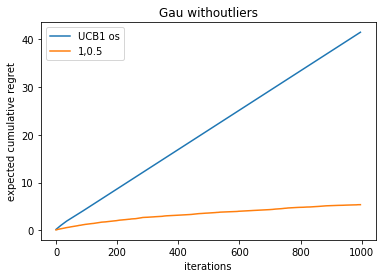

In [39]:
plt.plot(expected_regrets_UCB1_os_withoutliers, label = 'UCB1 os')
plt.plot(expected_regrets_true_var_gau_withoutliers, label = '1,0.5')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Gau withoutliers')
plt.legend()

From the above experiment, we can see when adding outliers, UCB1 performs much worse than our policy. UCB1 has a linear regret, reaching 40 regret at 1000th iterations. Then we show the performance for our policy with the hyperparameters we selected above (alpha = 0.2, beta = 0.5), for 10,000 iterations.

In [42]:
%%capture

# p = [0.01, 0.05, 0.1, 0.2]
num_rounds = 10000

regrets = []

for i in range(num_exper):
    agent = UCB_os_gau(rewards_env_with_outliers, num_rounds, medians, est_var = False, alpha = 0.2, beta = 0.5)
    regrets.append(agent.play())
    
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets_true_var_gau_withoutliers = np.mean(regrets, axis = 0)

In [43]:
%%capture

regrets = []

for i in range(num_exper):
    agent = UCB_os_gau(rewards_env, num_rounds, medians, est_var = False, alpha = 0.2, beta = 0.5)
    regrets.append(agent.play())
    
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets_true_var_gau = np.mean(regrets, axis = 0)

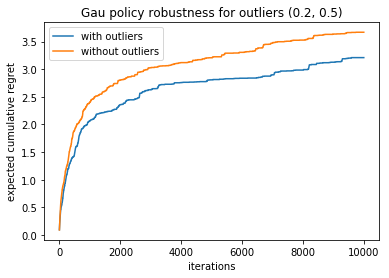

In [45]:
plt.plot(expected_regrets_true_var_gau_withoutliers, label = 'with outliers')
plt.plot(expected_regrets_true_var_gau, label = 'without outliers')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Gau policy robustness for outliers (0.2, 0.5)')
plt.legend()